In [1]:
"""
Lets start with a fairly simple and trivial SPN.
1. SPN -> Bayesian Network -> Q Bayesian Inference 
2. SPN -> Bayesian Network -> CNF -> QWMC Inference 
3. SPN -> CNF -> QInference ? 
4. SPN -> QInference ! 

Interesting questions: 
- Inference is already tractable in SPNs, are there intractable cases which we can make
  tractable by using QSPNs? 
- After considering Tractability, can we use QSPNs to for parameter or structure learning and 
  will this lead to a speedup? 
- We start by considering binary valued random variables. How can we encode continuous valued 
  random variables? Can we exploit continuous valued Quantum Computing methods? 
- Is there a way to make our Algorithm more efficient, especially considering a large amount 
  of random variables? Encoding each RV in one qubit seems rather inefficient, considering 
  our current top QCs only have 50 qubits. -> look for alternative encodings - complex encodings...
- Automated state preparation given a joint probability distribution / conditional probability 
  table is another interesting thing to check, as state prep can be rather bothersome. 
"""

'\nLets start with a fairly simple and trivial SPN.\n1. SPN -> Bayesian Network -> Q Bayesian Inference \n2. SPN -> Bayesian Network -> CNF -> QWMC Inference \n3. SPN -> CNF -> QInference ? \n4. SPN -> QInference ! \n\nInteresting questions: \n- Inference is already tractable in SPNs, are there intractable cases which we can make\n  tractable by using QSPNs? \n- After considering Tractability, can we use QSPNs to for parameter or structure learning and \n  will this lead to a speedup? \n- We start by considering binary valued random variables. How can we encode continuous valued \n  random variables? Can we exploit continuous valued Quantum Computing methods? \n- Is there a way to make our Algorithm more efficient, especially considering a large amount \n  of random variables? Encoding each RV in one qubit seems rather inefficient, considering \n  our current top QCs only have 50 qubits. -> look for alternative encodings - complex encodings...\n- Automated state preparation given a joi

In [2]:
from spn.structure.leaves.parametric.Parametric import Categorical, Bernoulli
from spn.structure.Base import Sum, Product
from spn.structure.Base import assign_ids, rebuild_scopes_bottom_up
from spn.io.Graphics import plot_spn

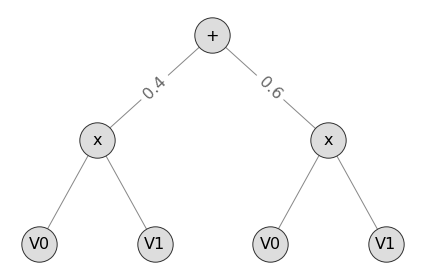

In [3]:
""" 
Our trivial SPN: 
"""

# Does swapping the probabilities correspond to the negation of a random variable? 
p2 = Product(children=[Bernoulli(p=[0.2], scope=0), Bernoulli(p=[0.5], scope=1)])
p4 = Product(children=[Bernoulli(p=[0.8], scope=0), Bernoulli(p=[0.5], scope=1)])

# p2 = Product(children=[Categorical(p=[0.2, 0.8], scope=0), Categorical(p=[0.6, 0.4], scope=1)])
# p4 = Product(children=[Categorical(p=[0.3, 0.7], scope=0), Categorical(p=[0.5, 0.5], scope=1)])
spn = Sum(weights=[0.4, 0.6], children=[p2, p4])

assign_ids(spn)
rebuild_scopes_bottom_up(spn)

plot_spn(spn, 'basicspn.png')

In [4]:
"""
We can map this SPN to a BN by hand, as it is in Normal Form: 

    H -> V0 
      -> V1 
      
With the conditional probability tables looking as follows: 
P(H=true) = 0.4     P(H=false) = 0.6
P(V0=true / H=true) = 0.2
P(V0=true / H=false) = 0.3
...
"""

'\nWe can map this SPN to a BN by hand, as it is in Normal Form: \n\n    H -> V0 \n      -> V1 \n      \nWith the conditional probability tables looking as follows: \nP(H=true) = 0.4     P(H=false) = 0.6\nP(V0=true / H=true) = 0.2\nP(V0=true / H=false) = 0.3\n...\n'

In [5]:
"""
Now let's do Bayesian Inference: mapping each RV to a Qubit by adjutsing the qubit probability 
amplitudes accordingly. 
"""

from qiskit import QuantumRegister, ClassicalRegister, BasicAer
from qiskit import QuantumCircuit, Aer
from qiskit import execute 

# Create one 4 qubit QuantumRegister to hold the 3 random variables and the ancilla qubit, 
# and a 3 bit ClassicalRegister to hold the sampled values 

qreg = QuantumRegister(4, 'qreg')
creg = ClassicalRegister(3, 'creg')

circuit = QuantumCircuit(qreg, creg, name='circuit')

In [6]:
# To encode the probabilities, let's set up a function that converts them to amplitudes 

import numpy as np 

def probToAngle(prob):
    return 2*np.arcsin(np.sqrt(prob))

In [7]:
# Setting up our qubits 
"""
    Query: P(V0=false / H=true) 
"""
H_0 = 0.4
H_1 = 0.6 

# For H=1: 
V0_0 = 0.7
V0_1 = 0.3

V1_0 = 0.2
V1_1 = 0.8

circuit.u3(probToAngle(H_1), 0, 0, qreg[0])
circuit.u3(probToAngle(V0_0), 0, 0, qreg[1])
circuit.u3(probToAngle(V1_0), 0, 0, qreg[2])


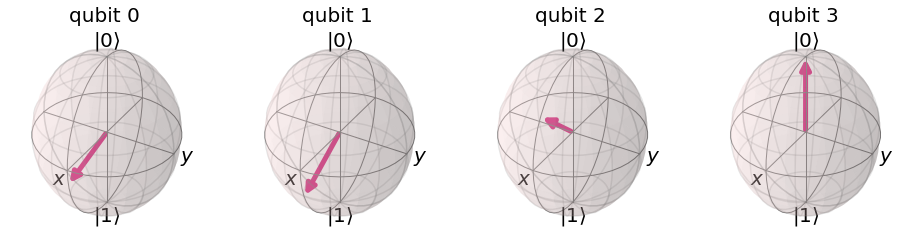

In [8]:
"""
    Plotting the qubits 
"""
from qiskit.tools.visualization import plot_histogram, plot_bloch_multivector


backend_statevector = BasicAer.get_backend('statevector_simulator')

job = execute(circuit, backend_statevector)
plot_bloch_multivector(job.result().get_statevector(circuit))

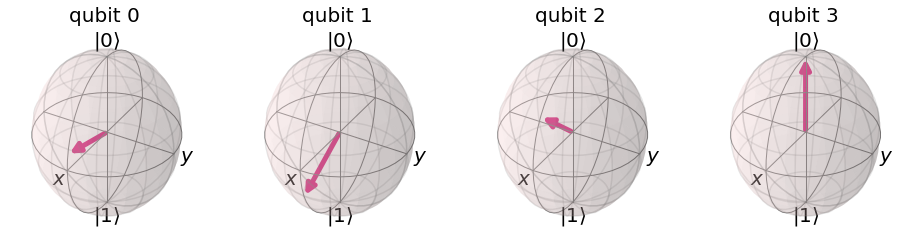

In [9]:
# Functions 
pi = np.pi

def oracle(circ):
    """
    Implements an oracle that flips the sign of states that contain H = 1.
    """
    circ.u3(pi, pi, 1, qreg[0])
    circ.u3(pi, pi, 1, qreg[0])    
    return circ


def u_gate(circ):
    """
    Implements the U gate that flips states about the average amplitude.
    """
    # Implements the quantum circuit that converts ψ -> |000...0>
    circ.u3(-1*probToAngle(H_1), 0, 0, qreg[0])
    circ.u3(-1*probToAngle(V0_0), 0, 0, qreg[1])
    circ.u3(-1*probToAngle(V1_0), 0, 0, qreg[2])

    # Flipping the |000...0> state using a triple controlled Z gate condtioned on P, E and H, 
    # and applied to the ancilla
    circ.x(qreg)
    circ.cu1(pi/4, qreg[0], qreg[3])
    circ.cx(qreg[0], qreg[1])
    circ.cu1(-pi/4, qreg[1], qreg[3])
    circ.cx(qreg[0], qreg[1])
    circ.cu1(pi/4, qreg[1], qreg[3])
    circ.cx(qreg[1], qreg[2])
    circ.cu1(-pi/4, qreg[2], qreg[3])
    circ.cx(qreg[0], qreg[2])
    circ.cu1(pi/4, qreg[2], qreg[3])
    circ.cx(qreg[1], qreg[2])
    circ.cu1(-pi/4, qreg[2], qreg[3])
    circ.cx(qreg[0], qreg[2])
    circ.cu1(pi/4, qreg[2], qreg[3])
    circ.x(qreg)

    # Implements the quantum circuit that converts |000...0> -> ψ 
    circ.u3(probToAngle(H_1), 0, 0, qreg[0])
    circ.u3(probToAngle(V0_0), 0, 0, qreg[1])
    circ.u3(probToAngle(V1_0), 0, 0, qreg[2])

    return circ


# Apply oracle and U gate twice
circuit = oracle(circuit)
circuit = u_gate(circuit)
circuit = oracle(circuit)
circuit = u_gate(circuit)
circuit.x(qreg[0])


backend_statevector = BasicAer.get_backend('statevector_simulator')
job = execute(circuit, backend_statevector)
plot_bloch_multivector(job.result().get_statevector(circuit))



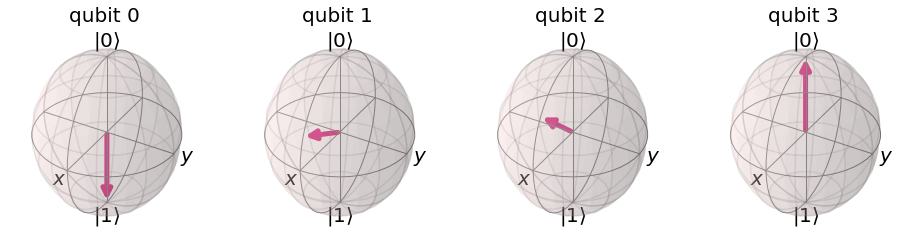

In [10]:
# Measure H and rotate V0 
circuit.measure(qreg[0], creg[0])
circuit.u3(probToAngle(V0_1) - probToAngle(V0_0), 0, 0, qreg[1])

backend_statevector = BasicAer.get_backend('statevector_simulator')
job = execute(circuit, backend_statevector)
plot_bloch_multivector(job.result().get_statevector(circuit))

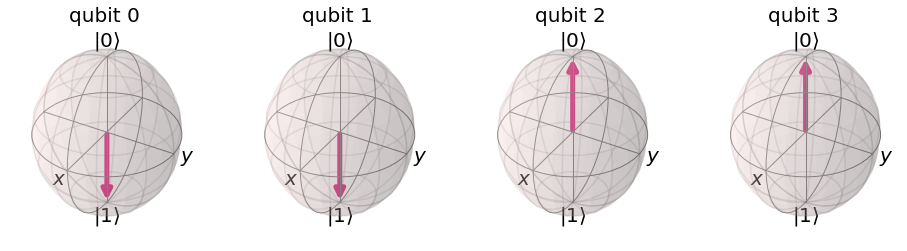

In [11]:
# Sample by measuring the rest of the qubits
circuit.measure(qreg[1], creg[1])
circuit.measure(qreg[2], creg[2])

backend_statevector = BasicAer.get_backend('statevector_simulator')
job = execute(circuit, backend_statevector)
plot_bloch_multivector(job.result().get_statevector(circuit))

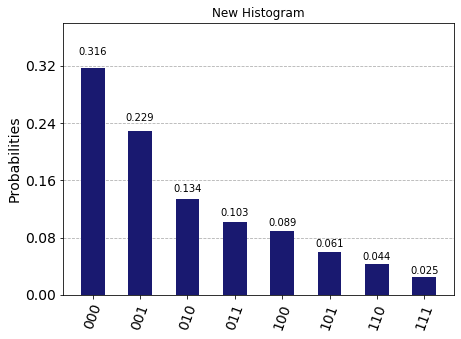

In [12]:
backend = BasicAer.get_backend('qasm_simulator')
job = execute(circuit, backend)
plot_histogram(job.result().get_counts(), color='midnightblue', title="New Histogram")

In [13]:
# Get backend from Aer provider
backend = Aer.get_backend('qasm_simulator')

# Run job many times to get multiple samples
samples_list = []
n_samples = 1000

for i in range(n_samples):
    job = execute(circuit, backend=backend, shots=1)
    result = list(job.result().get_counts(circuit).keys())[0]
    if result[2] == '0':
        samples_list.append(result)

# Printing the number of useful samples and percentage of samples rejected
print()
print(n_samples, 'samples drawn:', len(samples_list), 'samples accepted,', n_samples-len(samples_list), 'samples rejected.' )
print('Percentage of samples rejected: ', 100*(1 - (len(samples_list)/n_samples)), '%')

# Computing P(H = 0| P = 1)
p_H = 0

for i in samples_list:
    if i[0] == '1':
        p_H += 1

p_H /= len(samples_list)

print('P(V1 = 0| H = 1) =', p_H)
print()


1000 samples drawn: 592 samples accepted, 408 samples rejected.
Percentage of samples rejected:  40.800000000000004 %
P(V1 = 0| H = 1) = 0.19594594594594594

